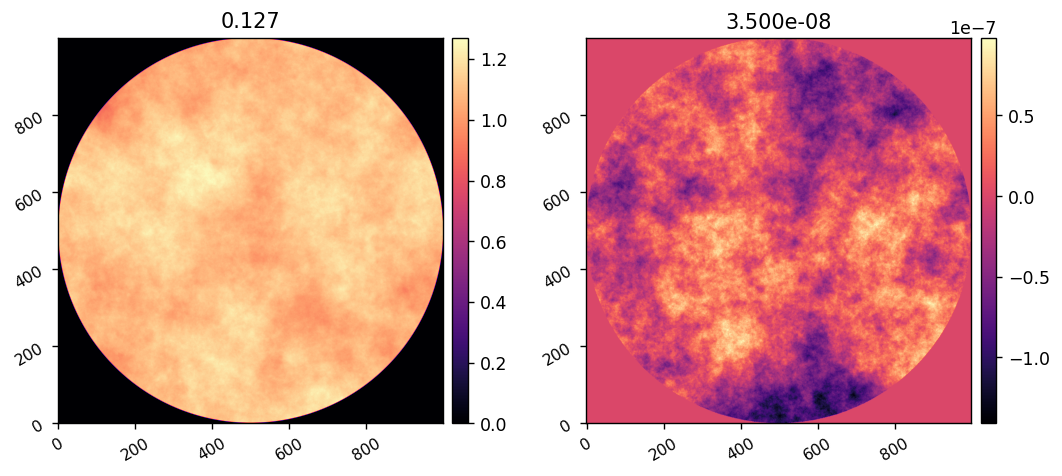

In [5]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob_oop as ad_scoob
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = 650e-9/2/np.pi * xp.angle(WFE)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

# Establish the forward model parameters.

In [11]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE

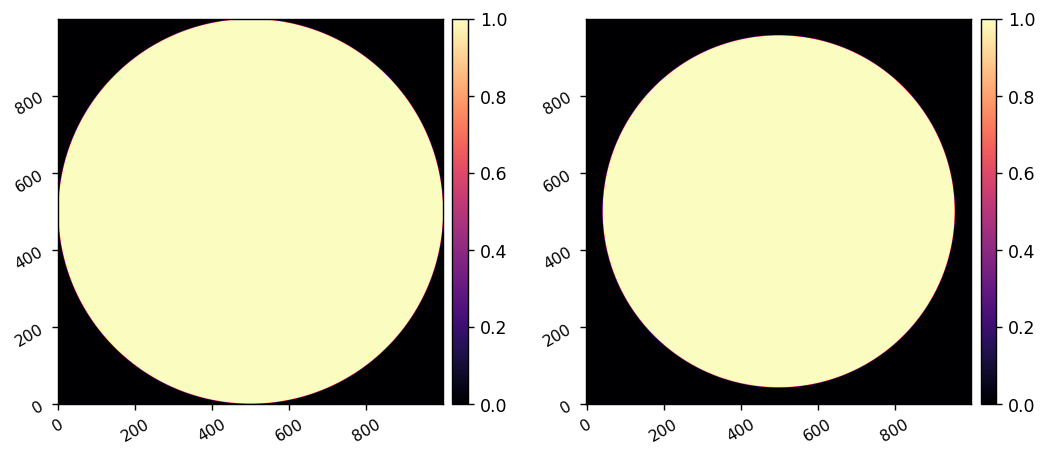

In [7]:
imshow2(m.APERTURE, m.LYOT, npix=m.npix)

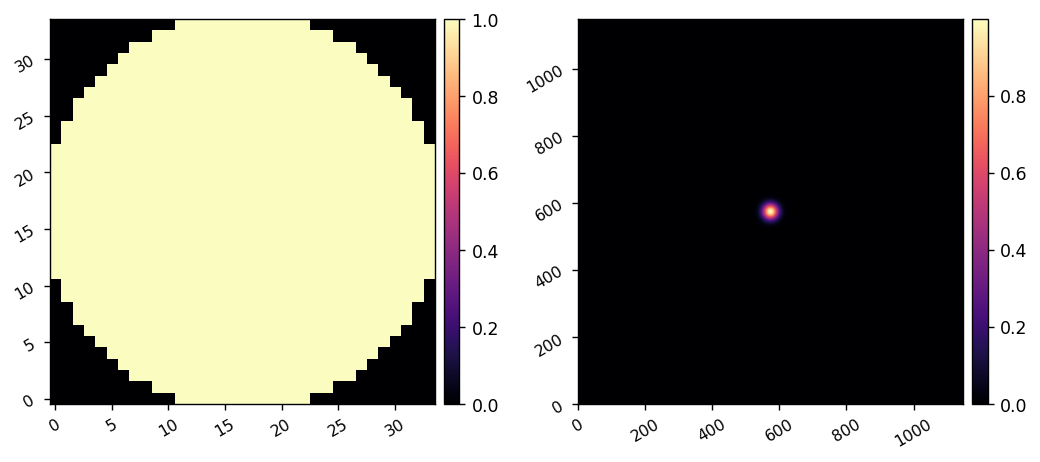

In [8]:
imshow2(m.dm_mask, m.inf_fun)

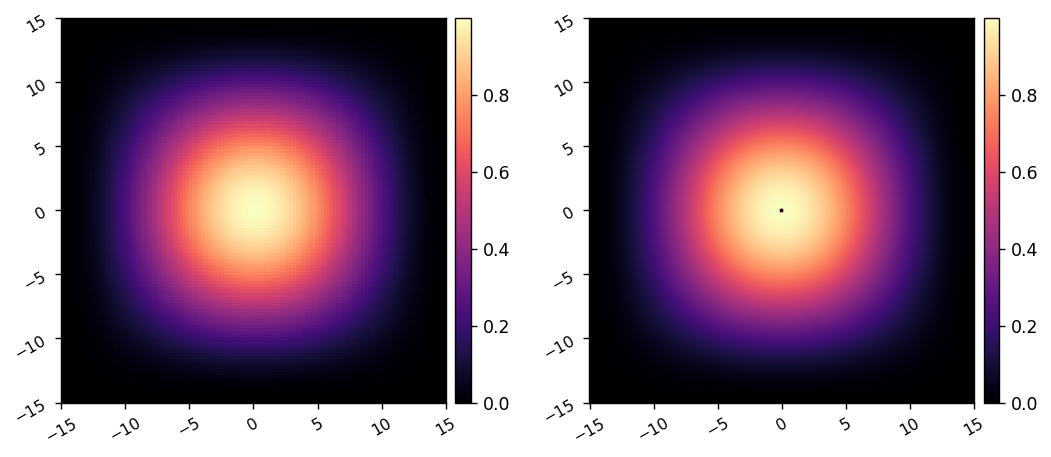

In [17]:
imshow2(m.lres_window, m.hres_window, npix1=m.lres_win_size,
        pxscl1=m.lres_sampling, pxscl2=m.hres_sampling)

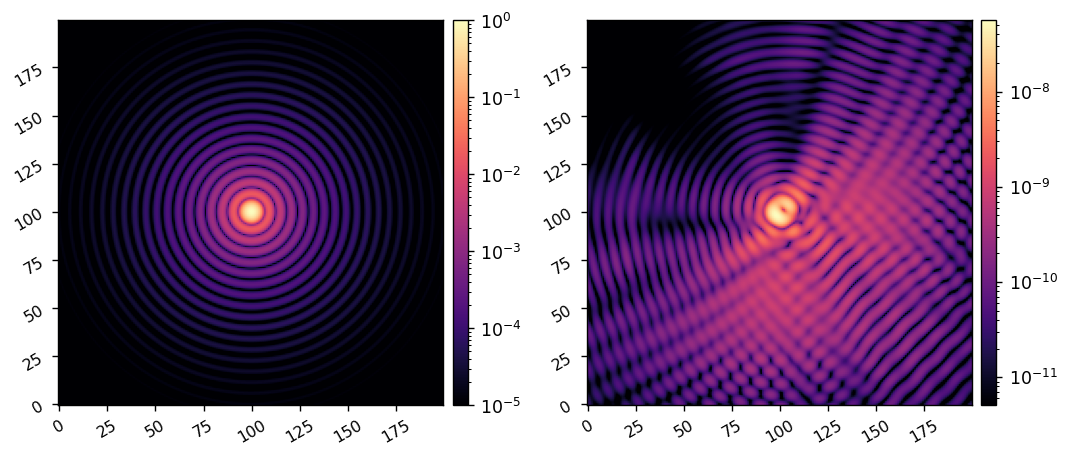

In [19]:
m.Imax_ref = 1
test_psf = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=False, use_wfe=False))**2
m.Imax_ref = xp.max(test_psf)
test_coro_im = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=True, use_wfe=False))**2
imshow2(test_psf/m.Imax_ref, test_coro_im, lognorm=True, vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)

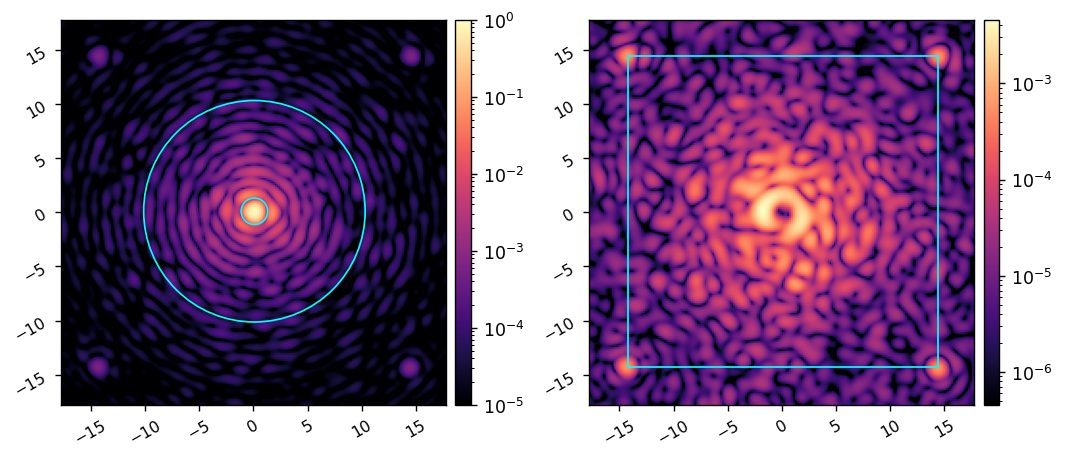

In [24]:
acts = np.zeros(m.Nacts)

waffle_command = 10e-9 * xp.ones((m.Nact,m.Nact))
waffle_command[1::2, ::2] *= -1
waffle_command[::2, 1::2] *= -1
acts = ensure_np_array(waffle_command[m.dm_mask]) 

m.Imax_ref = 1
ref_psf = xp.abs(m.forward(acts, use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow2(ref_psf/m.Imax_ref, ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)


# Test normal EFC

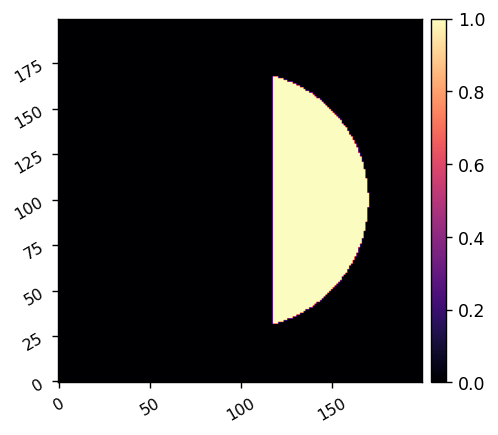

In [9]:
m.create_control_mask()
imshow1(m.control_mask)

In [20]:
reload(ad_scoob)

poke_modes = ad_scoob.create_poke_modes(m)

In [21]:
reload(ad_scoob)

jac = ad_scoob.compute_jacobian(m, poke_modes)


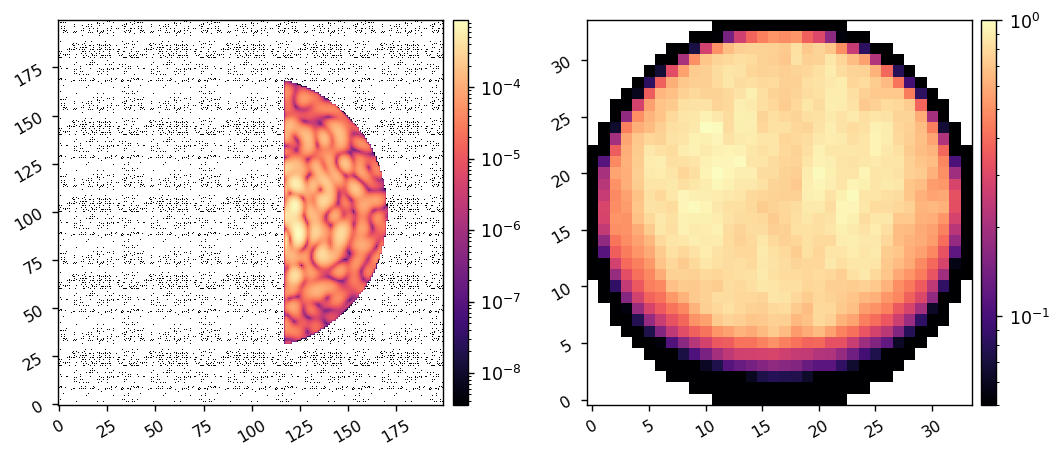

In [25]:
responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.sum(xp.square(xp.abs(responses.dot(poke_modes.reshape(m.Nacts, m.Nact**2)))), axis=0)).reshape(m.Nact,m.Nact)
dm_response /= dm_response.max()
imshow2(m.control_mask*ref_coro_im, dm_response, lognorm=True, vmin2=5e-2)

In [26]:
all_ims = []
all_efs = []
all_commands = []

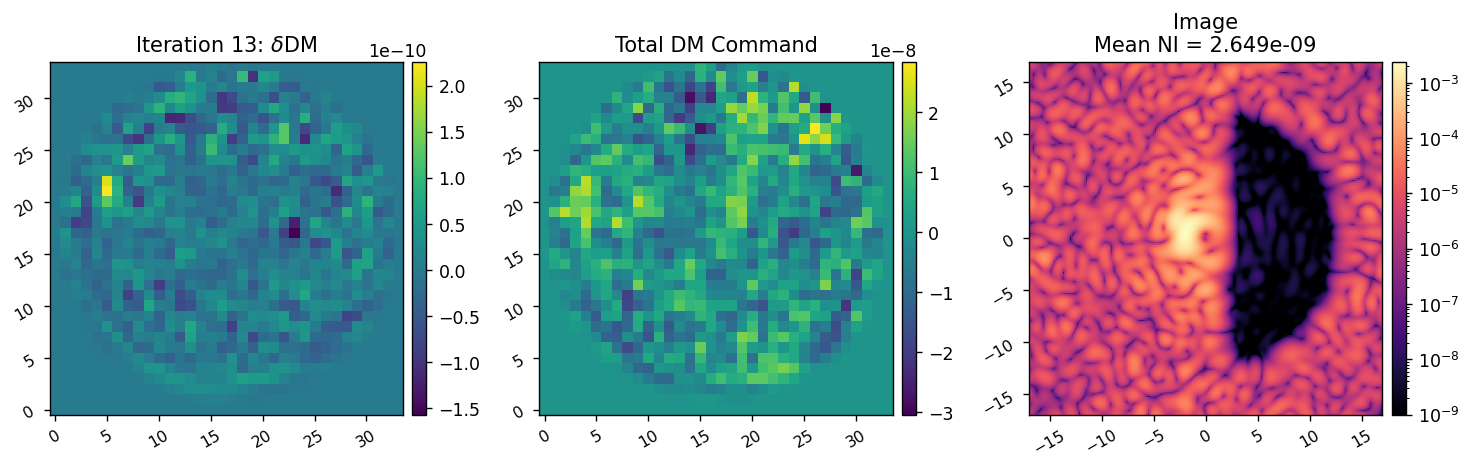

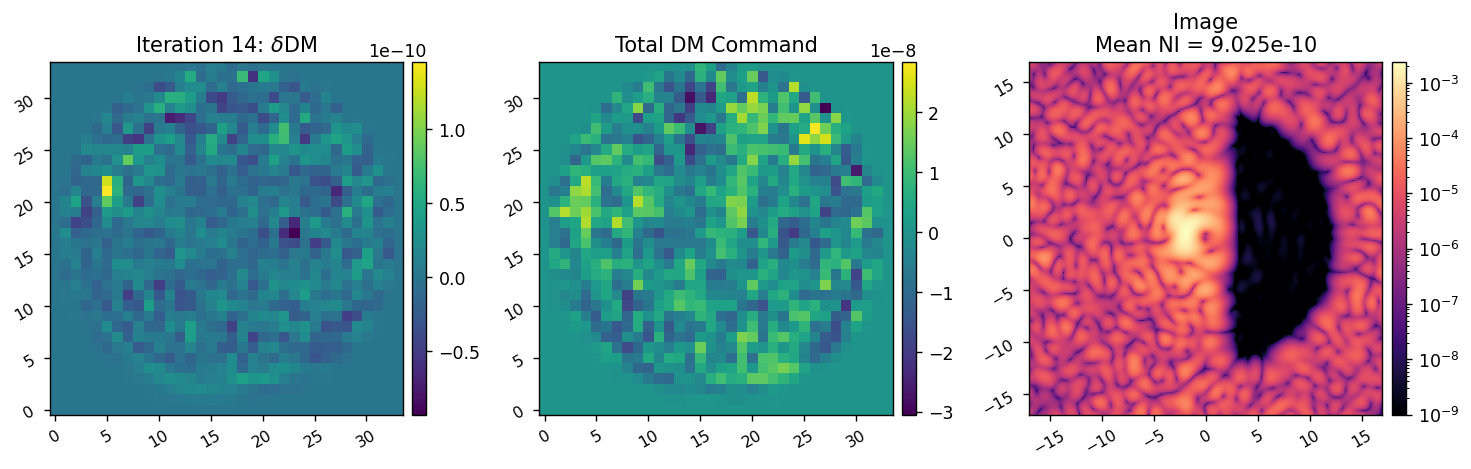

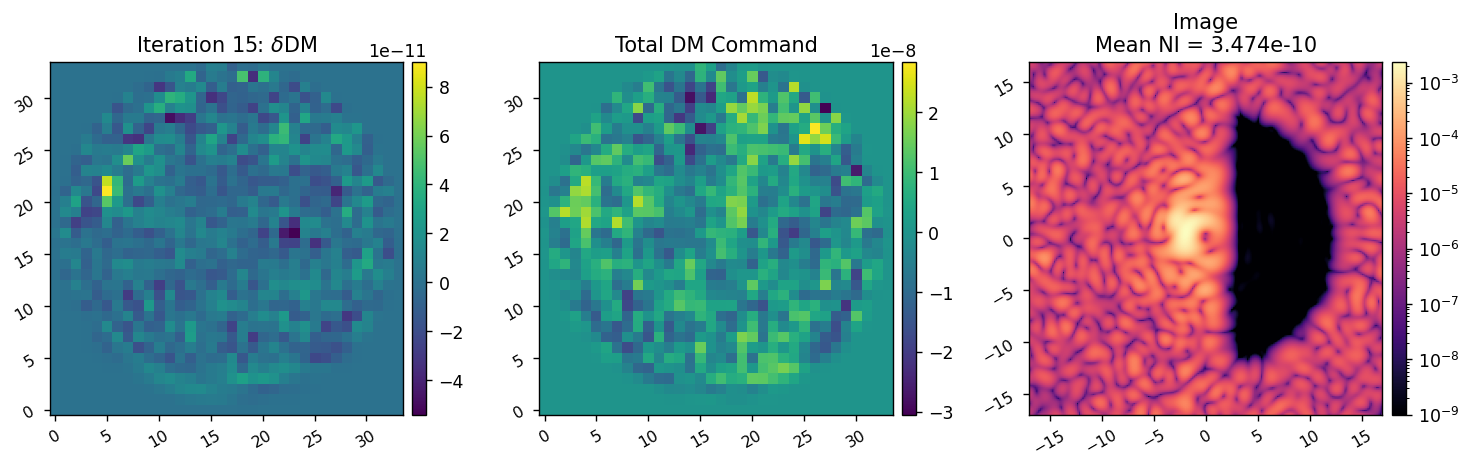

In [34]:
reload(ad_scoob)

cm = ad_scoob.beta_reg(jac, -2.5)
# cm = ad_scoob.beta_reg(jac, -4.5)

all_ims, all_efs, all_commands = ad_scoob.efc(m,
                                              cm, 
                                              Nitr=3, 
                                              nominal_command=all_commands[-1], 
                                              all_ims=all_ims, 
                                              all_efs=all_efs,
                                              all_commands=all_commands,
                                              )



# Test minimzation with L-BFGS-B

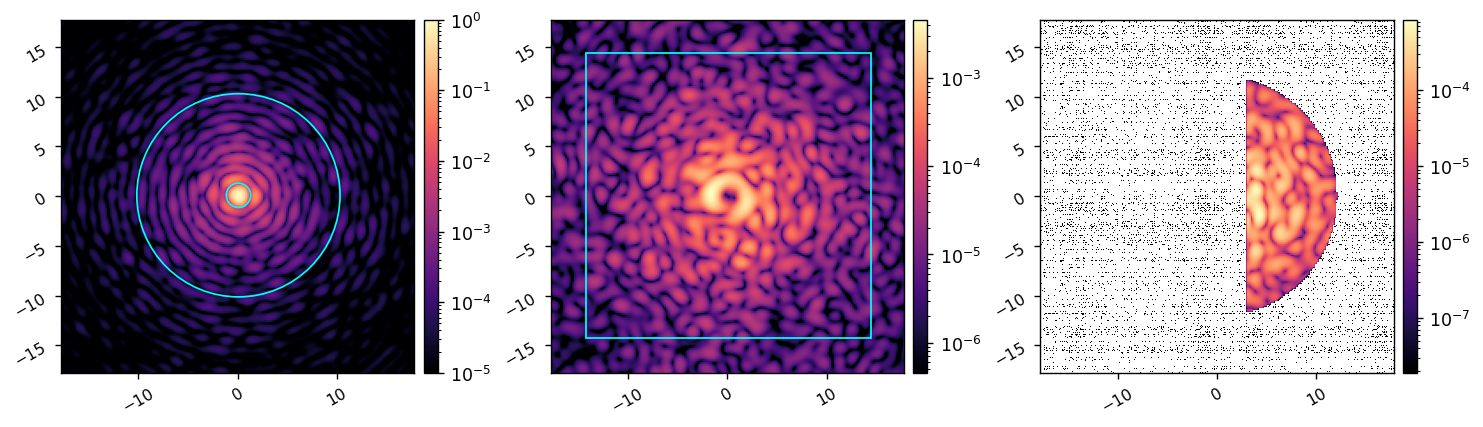

In [31]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE
m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = xp.abs(m.forward(acts, use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow3(ref_psf/m.Imax_ref, ref_coro_im, m.control_mask*ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True,  vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)

0.3260577535750728 0.0 0.3260577535750728 1.0


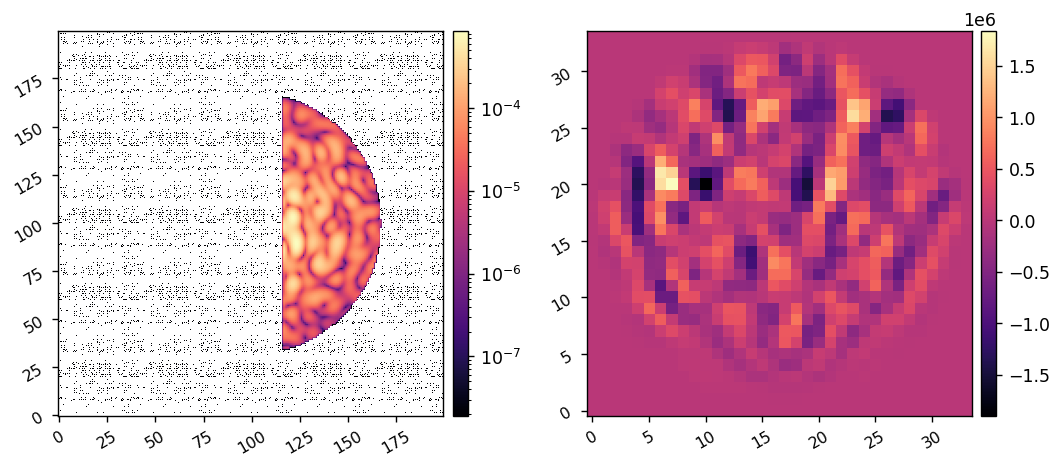

In [32]:
acts = np.zeros(m.Nacts)
del_acts = np.zeros(m.Nacts)

E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
E_target = 0
r_cond = 1e-2

J, dJ_dA = m.val_and_grad(del_acts, 
                          acts, 
                          E_ab,
                          E_target=E_target, 
                          r_cond=r_cond,
                          verbose=True,
                          )

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
imshow2(m.control_mask*ref_coro_im, dm_grad, lognorm1=True)

# Does E_ep_k-1 contain the wavefront contribution from the total accumulated DM command?

In [33]:
acts = np.zeros(m.Nacts)
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
E_target = 0
r_cond = 1e-2

bfgs_tol = 1e-3
bfgs_opts = {
    'maxiter':20,
    # 'maxls':30, # default is 20
    'ftol':1e-6, 
    'gtol':1e-6,
    'disp':True, 
}

del_acts0 = np.zeros(m.Nacts)
res = minimize(m.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(acts, E_ab, E_target, r_cond), 
                method='L-BFGS-B',
                #    method='CG',
                tol=bfgs_tol,
                options=bfgs_opts,
                )
    

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45358D+00    |proj g|=  4.62669D+06

At iterate    1    f=  5.22798D-01    |proj g|=  1.40079D+06

At iterate    2    f=  2.09518D-01    |proj g|=  7.81302D+05

At iterate    3    f=  9.19666D-02    |proj g|=  8.50094D+05

At iterate    4    f=  8.77111D-02    |proj g|=  9.34384D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  8.08197D-02    |proj g|=  1.02820D+06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  952      6     97      3     0     0   1.028D+06   8.082D-02
  F =   8.0819674134847044E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              


6.667847721371633e-05 0.009824800248615739


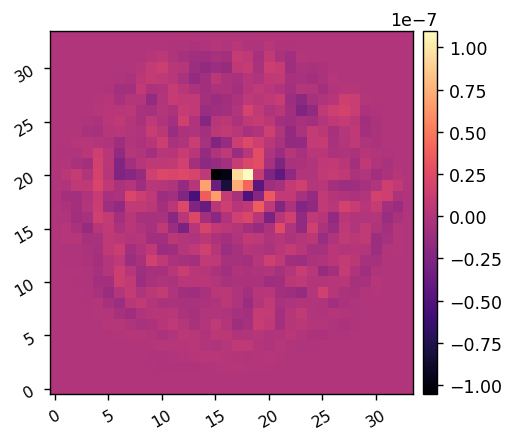

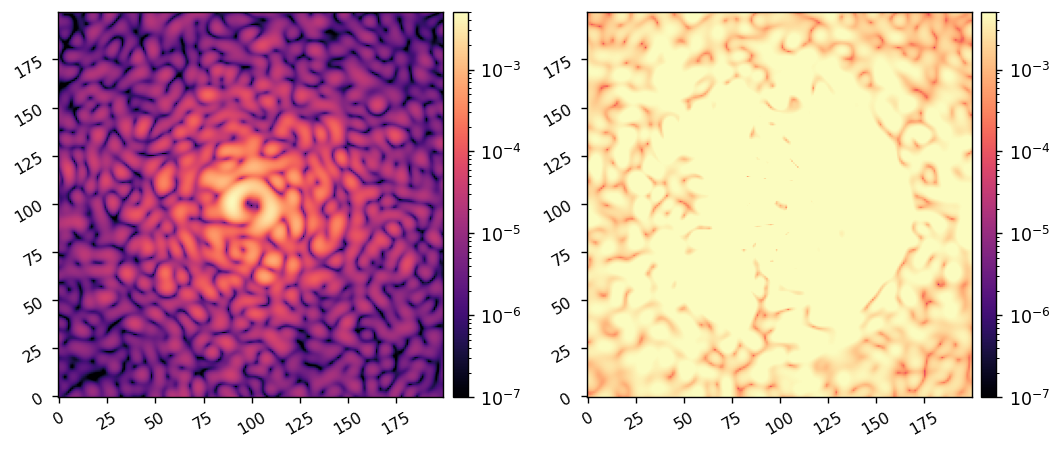

In [36]:
min_command = xp.zeros((m.Nact,m.Nact))
min_command[m.dm_mask] = res.x
coro_im = xp.abs(m.forward(res.x, use_wfe=True))

print(xp.mean(ref_coro_im[m.control_mask]), xp.mean(coro_im[m.control_mask]))
imshow1(min_command)
imshow2(ref_coro_im, coro_im, lognorm=True, vmin1=1e-7, vmin2=1e-7, vmax1=5e-3, vmax2=5e-3)

# Test a full EFC run with L-BFGS-B

In [ ]:
control_mask = create_control_mask(iwa=3, owa=12, edge=3, rotation=0)
Nmask = int(control_mask.sum())
imshow1(control_mask)

In [36]:
all_ims = []
all_efs = []
all_commands = []

bfgs_tol = 1e-3
bfgs_opts = {
    'maxiter':20,
    # 'maxls':30, # default is 20
    'ftol':1e-6, 
    'gtol':1e-6,
    'disp':False, 
}

In [ ]:
reg_cond = 1e-2
# reg_cond = 1e-3
# reg_cond = 1e-4

all_ims, all_efs, all_commands = ad_efc(Nitr=3, 
                                        nominal_command=all_commands[-1], 
                                        reg_cond=reg_cond,
                                        bfgs_tol=bfgs_tol,
                                        bfgs_opts=bfgs_opts,
                                        all_ims=all_ims,
                                        all_efs=all_efs,
                                        all_commands=all_commands,
                                        )
